In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
from typing import List

In [44]:
plt.style.use("dark_background")


# Load train data

In [45]:
data = pd.read_csv(r'C:\Users\User\Desktop\Projects\Kaggle\Kaggle_Practice\spaceship_titanic\data\train.csv', index_col='PassengerId')
data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [46]:
target_col = 'Transported'

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 891.4+ KB


# PreProcessing for analysis

`expenditures` consists of columns regarding expenses. As there 5 different expenses columns I would like to sum them for a `Total_exp` feature. This will help dealing with nulls, bias and should simplify the explaining features for the model

In [ ]:

expenditures = ["RoomService", 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [49]:
def preprocess(data: pd.DataFrame, cols2sum: List[str]):
    data['Total_exp'] = data[cols2sum].sum(axis=1)
    data["InGroup"]   = create_ingroup_from_index(data)
    parsed_cabin = parse_cabin(data)

    return parsed_cabin.drop(['Name'], axis=1)

def parse_cabin(data: pd.DataFrame):
    data['Deck']     = data['Cabin'].apply(lambda x: x.split(sep='/')[0] if type(x) == str else x)
    # data['Cabin_#']  = data['Cabin'].apply(lambda x: x.split(sep='/')[1] if type(x) == str else x)
    data['Portside'] = data['Cabin'].apply(lambda x: x.split(sep='/')[2] if type(x) == str else x)

    return data.drop(['Cabin'] + expenditures, axis=1)

def create_ingroup_from_index(data: pd.DataFrame):
    df = data.index.to_frame()
    df[['group_id', 'ingroup_id']] = df['PassengerId'].str.split("_", n = 1, expand = True)
    grouped = df.groupby('group_id').count()
    grouped['ingroup'] = np.where(grouped['ingroup_id'] > 1, 1, 0)
    return pd.merge(df['group_id'], grouped['ingroup'], left_on=['group_id'], right_index=True)['ingroup']


In [50]:
df = preprocess(data=data, cols2sum=expenditures)
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,Total_exp,InGroup,Deck,Portside
PassengerId,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,False,0.0,0,B,P
0002_01,Earth,False,TRAPPIST-1e,24.0,False,True,736.0,0,F,S
0003_01,Europa,False,TRAPPIST-1e,58.0,True,False,10383.0,1,A,S
0003_02,Europa,False,TRAPPIST-1e,33.0,False,False,5176.0,1,A,S
0004_01,Earth,False,TRAPPIST-1e,16.0,False,True,1091.0,0,F,S


# Nulls

In [51]:
df.isnull().sum()

HomePlanet     201
CryoSleep      217
Destination    182
Age            179
VIP            203
Transported      0
Total_exp        0
InGroup          0
Deck           199
Portside       199
dtype: int64

# Plots

##### Age

In [75]:
df['Age'].describe().to_frame()

,Age
count,8514.000000
mean,28.827930
std,14.489021
min,0.000000
25%,19.000000
50%,27.000000
75%,38.000000
max,79.000000


<Axes: xlabel='Age', ylabel='Count'>

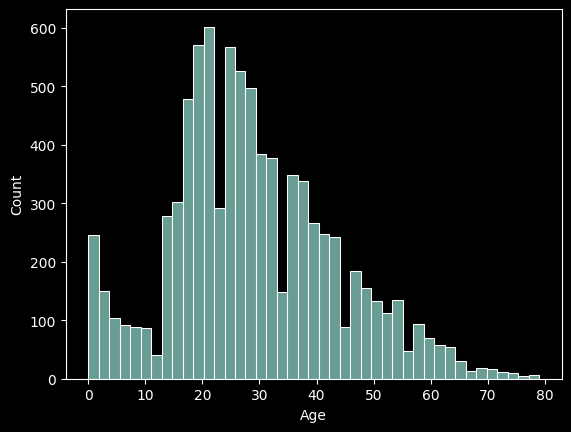

In [76]:
sns.histplot(df['Age'])

##### Destination

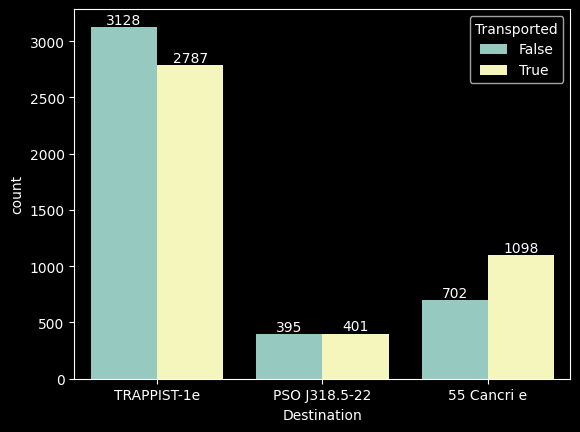

In [55]:
ax = sns.countplot(data=df, x='Destination', hue=target_col)
for i in ax.containers:
    ax.bar_label(i,)

##### HomePlanet

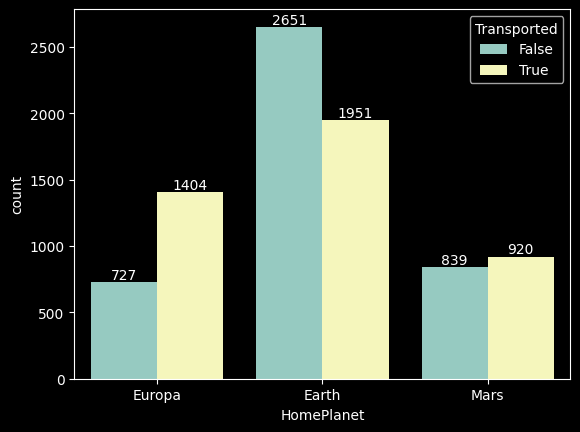

In [56]:
ax = sns.countplot(data=df, x='HomePlanet', hue=target_col)
for i in ax.containers:
    ax.bar_label(i,)

##### Deck

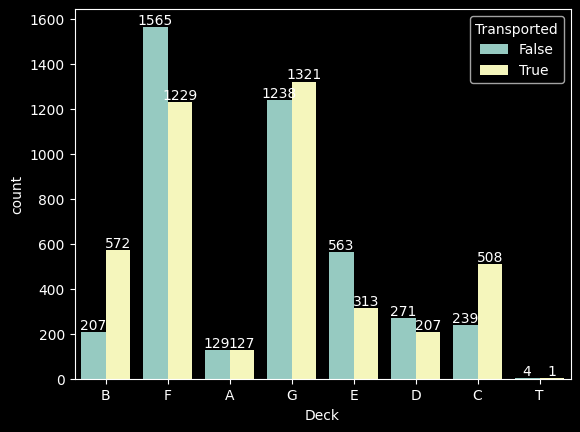

In [57]:
ax = sns.countplot(data=df, x='Deck', hue=target_col)
for i in ax.containers:
    ax.bar_label(i,)

##### Portside

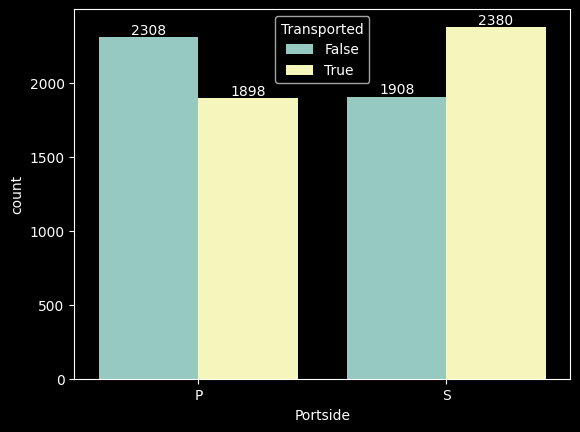

In [58]:
ax = sns.countplot(data=df, x='Portside', hue=target_col)
for i in ax.containers:
    ax.bar_label(i,)

##### CryoSleep

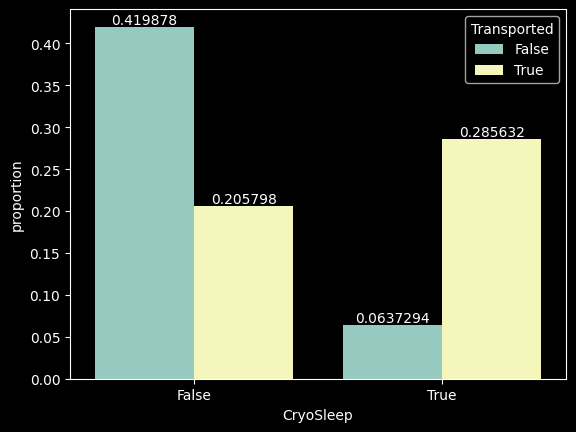

In [68]:
ax = sns.countplot(data=df, x='CryoSleep', hue=target_col, stat='proportion')
for i in ax.containers:
    ax.bar_label(i,)

##### VIP

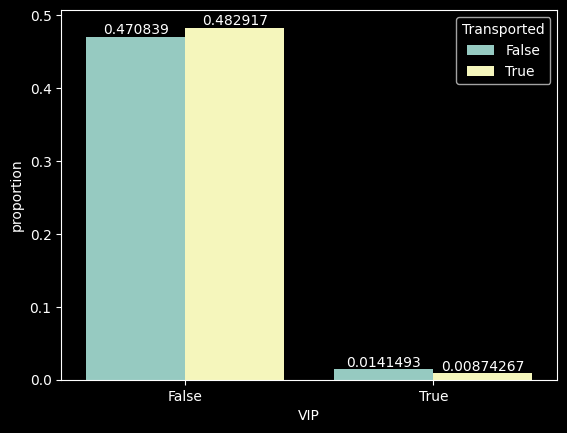

In [69]:
ax = sns.countplot(data=df, x='VIP', hue=target_col, stat='proportion')
for i in ax.containers:
    ax.bar_label(i,)

##### Total expenses

(<Axes: xlabel='Total_exp', ylabel='Count'>,
 count     8693.000000
 mean      1440.866329
 std       2803.045694
 min          0.000000
 25%          0.000000
 50%        716.000000
 75%       1441.000000
 max      35987.000000
 Name: Total_exp, dtype: float64)

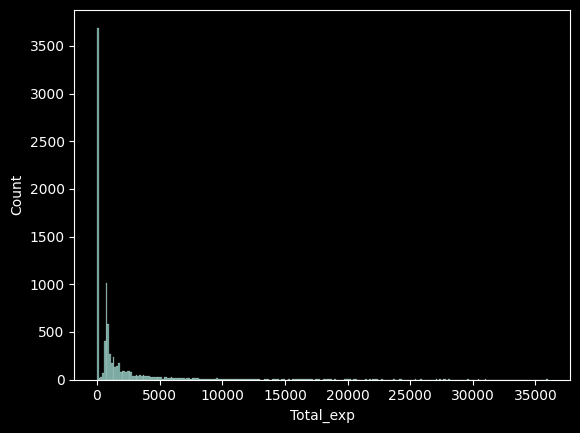

In [61]:
sns.histplot(df['Total_exp']), df['Total_exp'].describe()

# Corr

## `VIP` & `CryoSleep` (Boolean) corr

In [59]:
df[[target_col, 'VIP', 'CryoSleep']].corr()

,Transported,VIP,CryoSleep
Transported,1.000000,-0.037650,0.468645
VIP,-0.037650,1.000000,-0.081402
CryoSleep,0.468645,-0.081402,1.000000


##### `Total_exp` as Boolean corr

In [72]:
temp_corr_df = df[[target_col, "Total_exp"]].copy()
temp_corr_df["spended"] = temp_corr_df['Total_exp'].astype(bool)
temp_corr_df[[target_col, 'spended']].corr()

,Transported,spended
Transported,1.000000,-0.481628
spended,-0.481628,1.000000
